In [1]:
import glob
import cv2
import numpy as np
from skimage import io
import albumentations as A

import matplotlib.pyplot as plt

import wandb

import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from monai.inferers import SlidingWindowInferer

%load_ext autoreload
%autoreload 2
from venomai import unet, loader, metrics, predictor, preprocess

In [2]:
def augment_slice(image_patch):
    
    transform = A.Compose([
        A.RGBShift(p=1, r_shift_limit=40, g_shift_limit=40, b_shift_limit=40),
    ])
    
    transformed = transform(image=image_patch)
    image_patch = transformed['image']
    return image_patch

def white_balance(image):
    # Convert to linear RGB color space
    image = preprocess.srgb_to_linear(image)

    # Apply automatic white balancing
    image = preprocess.auto_white_balance(image)

    # Apply template white balancing
    inner_area=10**2
    black_square = preprocess.find_black_square(image[int(image.shape[0]/2):,:,:])
    white_point, black_point, pixel_resolution = preprocess.compute_square_info([black_square], inner_area=inner_area)
    print(pixel_resolution)

    image = preprocess.white_balance(image, white_point, black_point)

    # Convert back to gamma RGB color space
    image = preprocess.linear_to_srgb(image)
    
    # Rescale image to have a resolution of 5 pixels per mm
    image = preprocess.rescale_image(image, pixel_resolution, target_res=5, interpolation=cv2.INTER_CUBIC)
    return image

9.924716620639606
(3864, 5152, 3) (1947, 2596, 3)


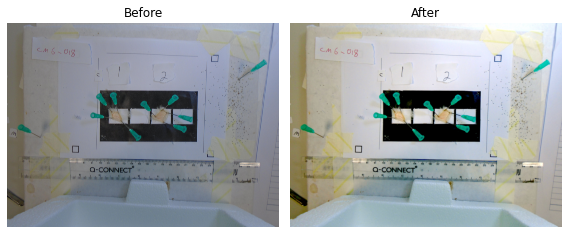

10.093562304756434
(3864, 5152, 3) (1914, 2552, 3)


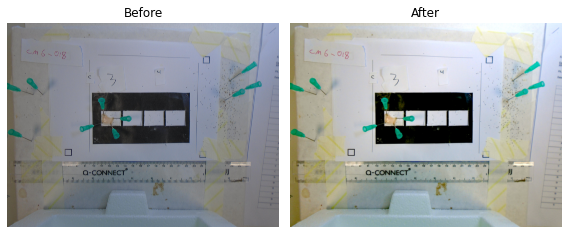

12.899612397277679
(3864, 5152, 3) (1498, 1997, 3)


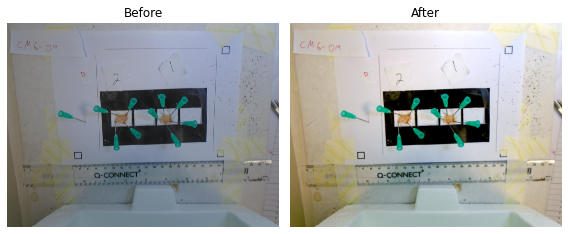

11.042191811411355
(3864, 5152, 3) (1750, 2333, 3)


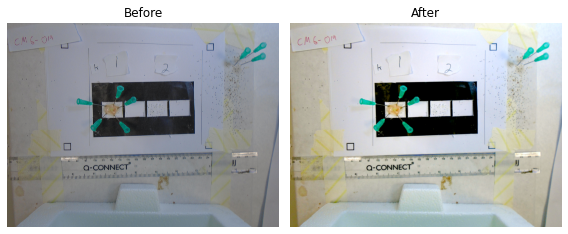

13.857849761056004
(3864, 5152, 3) (1394, 1859, 3)


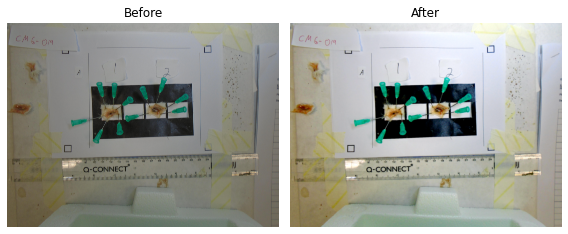

10.56882207249228
(3864, 5152, 3) (1828, 2437, 3)


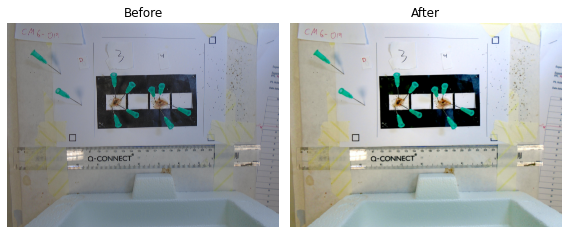

In [3]:
image_files = np.sort(glob.glob('data/raw/images/*'))
idx = [79,126,96,129,16,65]
image_files = image_files[idx]

for i in range(len(image_files)):

    # Load original image
    image_base = io.imread(image_files[i])
    io.imsave(f'figures/white_balance/wb_{i}_before.png', image_base)

    image = white_balance(image_base)
    io.imsave(f'figures/white_balance/wb_{i}_after.png', image)

    print(image_base.shape, image.shape)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

    ax1.set_title('Before')
    ax1.imshow(image_base)
    ax1.axis('off')

    ax2.set_title('After')
    ax2.imshow(image)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

9.845303448853164


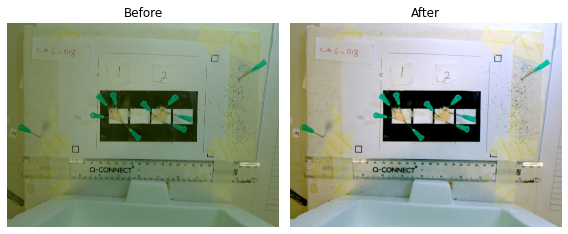

11.139120252515458


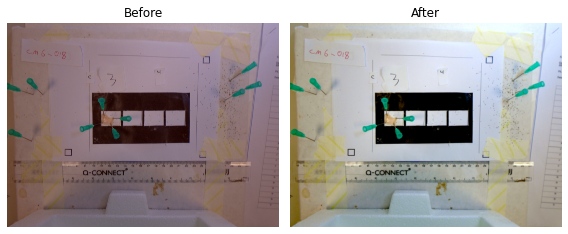

13.710215169719257


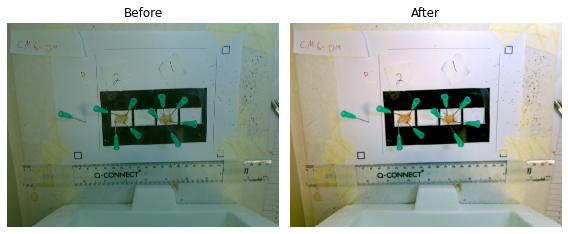

11.014081895464551


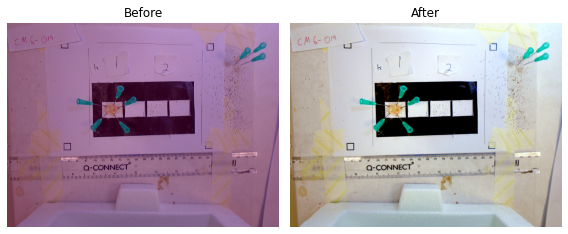

12.60515767453942


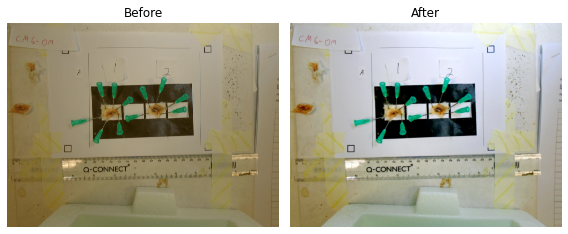

16.397560794215707


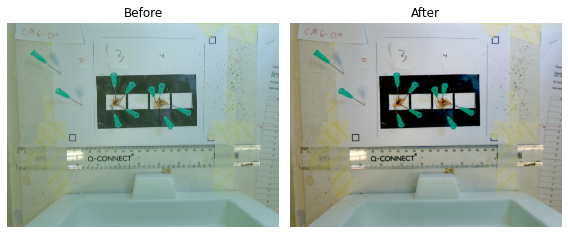

In [3]:
image_files = np.sort(glob.glob('data/raw/images/*'))
idx = [79,126,96,129,16,65]
image_files = image_files[idx]

for i in range(len(image_files)):

    # Load original image
    image = io.imread(image_files[i])

    image_augmented = augment_slice(image)
    io.imsave(f'figures/white_balance_stress_test/wb_{i}_before.png', image_augmented)

    image = white_balance(image_augmented)
    io.imsave(f'figures/white_balance_stress_test/wb_{i}_after.png', image)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

    ax1.set_title('Before')
    ax1.imshow(image_augmented)
    ax1.axis('off')

    ax2.set_title('After')
    ax2.imshow(image)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()